# Compare
### Models
1. BPR: Bayesian Personalized Ranking from Implicit Feedback
https://arxiv.org/abs/1205.2618
    1. Optimizes for AUC
2. (WARP) WSABIE: Scaling Up To Large Vocabulary Image Annotation http://www.thespermwhale.com/jaseweston/papers/wsabie-ijcai.pdf
    1. Optimizes for Precision@k
3. (k-OS WARP) Learning to Rank Recommendations with the k-Order Statistic Loss https://research.google.com/pubs/pub41534.html
    1. Optimizes for Precision@k
4. CLiMF: Learning to Maximize Reciprocal Rank with Collaborative Less-is-More Filtering
http://baltrunas.info/papers/Shi12-climf.pdf
    1. Optimizes for Reciprocal Rank

### Optimizers (other than vanilla SGD)
1. [NAdam](http://cs229.stanford.edu/proj2015/054_report.pdf)
2. [Nesterov](https://distill.pub/2017/momentum/)

### Data
- Movielens 100k https://grouplens.org/datasets/movielens/100k/
- README - http://files.grouplens.org/datasets/movielens/ml-100k-README.txt


## TODO
- speed up implementations (cython, c++, or numba/bottleneck)

In [1]:
import os
import pandas as pd
from scipy.sparse import coo_matrix, csr_matrix, diags
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import log_loss, accuracy_score, roc_curve, roc_auc_score
from sklearn.utils.extmath import safe_sparse_dot
import time
import math

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [45]:
from warp import WARPNaive, KosWARP
from bpr import BPR
from climf import CLiMF
from optimizers import SGD, NAdam

In [4]:
dtype = np.float32

# load data

In [5]:
data_dir = "/Users/timwee/projects/datasets/movielens/ml-100k"

def load_data_from_f(fpath):
    # columns - user id | item id | rating | timestamp
    # user_id and item_id numbered consecutively from 1
    with open(fpath) as f:
        users, items, ratings = [], [], []
        max_user = -1
        max_item = -1
        for line in f:
            user_id, item_id, rating, ts = [int(tok) for tok in line.strip().split("\t")]
            # make it zero indexed
            user_id -= 1
            item_id -= 1
            max_user = max(max_user, user_id)
            max_item = max(max_item, item_id)
            users.append(user_id) 
            items.append(item_id)
            ratings.append(rating)
        return np.array(users), np.array(items), np.array(ratings), max_user, max_item


def train_and_test_data(data_dir, train_fname="ua.base", test_fname="ua.test", dtype=np.float32):
    trn_u, trn_i, trn_r, max_trn_u, max_trn_i = load_data_from_f(os.path.join(data_dir, train_fname))
    tst_u, tst_i, tst_r, max_tst_u, max_tst_i = load_data_from_f(os.path.join(data_dir, test_fname))
    num_rows = max(max_trn_u, max_tst_u) + 1
    num_cols = max(max_trn_i, max_tst_i) + 1
    return {"train" : coo_matrix((trn_r, (trn_u, trn_i)), shape=(num_rows, num_cols), dtype=dtype).tocsr(), \
            "test" : coo_matrix((tst_r, (tst_u, tst_i)), shape=(num_rows, num_cols), dtype=dtype).tocsr()}
    

In [6]:
movielens = train_and_test_data(data_dir, dtype=dtype)
train, test = movielens["train"], movielens["test"]
num_users, num_items = train.shape
train.shape, test.shape

((943, 1682), (943, 1682))

## helpers

In [88]:
def plot_metrics(toplot, xlabel, ylabel, title, ax):
    legend_lines = []
    legend_names = []
    for label, (xs, ys) in toplot.items():
        legend_lines.append(ax.plot(xs, ys, label=label)[0])
        legend_names.append(label)
    ax.legend(legend_lines, legend_names)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

In [26]:
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k, reciprocal_rank

In [10]:
num_epochs = 100
eval_interval = 10

# CLiMF

### Vanilla SGD

In [12]:
durations = []
tst_climf_auc = []
tst_climf_prec5 = []
tst_climf_rr = []

# override lr
lrate = 1e-4
decay = 5e-4

climf_model = CLiMF(lr=1e-4, reg=0.001)
for epoch in range(num_epochs+1):
    start = time.time()
    climf_model.fit(train, lr=lrate, debug=False, reset=False)
    lrate *= (1. / (1. + (decay * i)))
    duration = time.time() - start
    if (epoch % eval_interval) == 0 or epoch == num_epochs:
        durations.append(duration)    
        tst_auc = auc_score(climf_model, test, train_interactions=train).mean()
        tst_prec5 = precision_at_k(climf_model, test, train_interactions=train, k=5).mean()
        tst_rr = reciprocal_rank(climf_model, test, train_interactions=train).mean()
        tst_climf_auc.append(tst_auc)
        tst_climf_prec5.append(tst_prec5)
        tst_climf_rr.append(tst_rr)
        print("iteration %d took %.4f, auc: %.4f, p@5: %.4f, rr: %.4f" % \
              (epoch, duration, tst_auc, tst_prec5, tst_rr))

initializing embeddings
iteration 0 took 9.0213, auc: 0.4995, p@5: 0.0062, rr: 0.0342
iteration 10 took 9.3370, auc: 0.5213, p@5: 0.0191, rr: 0.0725
iteration 20 took 9.1028, auc: 0.5632, p@5: 0.0386, rr: 0.1095
iteration 30 took 9.1309, auc: 0.6008, p@5: 0.0522, rr: 0.1433
iteration 40 took 9.0532, auc: 0.6266, p@5: 0.0607, rr: 0.1661
iteration 50 took 9.6576, auc: 0.6422, p@5: 0.0687, rr: 0.1838
iteration 60 took 9.6209, auc: 0.6512, p@5: 0.0734, rr: 0.1956
iteration 70 took 9.2395, auc: 0.6565, p@5: 0.0764, rr: 0.2006
iteration 80 took 9.5704, auc: 0.6598, p@5: 0.0772, rr: 0.2028
iteration 90 took 9.2310, auc: 0.6617, p@5: 0.0778, rr: 0.2043
iteration 100 took 9.0222, auc: 0.6629, p@5: 0.0780, rr: 0.2067


### Nesterov Momentum

In [43]:
durations2 = []
tst_climf_auc2 = []
tst_climf_prec52 = []
tst_climf_rr2 = []

climf_sgd = SGD(lr=1e-4, decay=5e-4, nesterov=True, momentum=0.5)

climf_model2 = CLiMF(climf_sgd, reg=0.001)
for epoch in range(num_epochs+1):
    start = time.time()
    climf_model2.fit(train, cur_iter=epoch, debug=False, reset=False)
    duration = time.time() - start
    if (epoch % eval_interval) == 0 or epoch == num_epochs:
        durations2.append(duration)    
        tst_auc = auc_score(climf_model2, test, train_interactions=train).mean()
        tst_prec5 = precision_at_k(climf_model2, test, train_interactions=train, k=5).mean()
        tst_rr = reciprocal_rank(climf_model2, test, train_interactions=train).mean()
        tst_climf_auc2.append(tst_auc)
        tst_climf_prec52.append(tst_prec5)
        tst_climf_rr2.append(tst_rr)
        print("iteration %d took %.4f, auc: %.4f, p@5: %.4f, rr: %.4f" % \
              (epoch, duration, tst_auc, tst_prec5, tst_rr))

initializing embeddings
iteration 0 took 9.2301, auc: 0.4996, p@5: 0.0068, rr: 0.0367
iteration 10 took 10.4144, auc: 0.6316, p@5: 0.0568, rr: 0.1559
iteration 20 took 12.5902, auc: 0.7873, p@5: 0.1177, rr: 0.2952
iteration 30 took 12.2311, auc: 0.8191, p@5: 0.1236, rr: 0.3223
iteration 40 took 11.4047, auc: 0.7902, p@5: 0.1205, rr: 0.3049
iteration 50 took 18.8985, auc: 0.7843, p@5: 0.1232, rr: 0.3204
iteration 60 took 11.7248, auc: 0.7786, p@5: 0.1328, rr: 0.3292
iteration 70 took 11.3817, auc: 0.7844, p@5: 0.1449, rr: 0.3454
iteration 80 took 11.6818, auc: 0.7882, p@5: 0.1540, rr: 0.3541
iteration 90 took 11.2377, auc: 0.7996, p@5: 0.1578, rr: 0.3559
iteration 100 took 11.1826, auc: 0.8094, p@5: 0.1705, rr: 0.3636


In [48]:
durations_climf_nadam = []
tst_climf_auc_climf_nadam = []
tst_climf_prec5_climf_nadam = []
tst_climf_rr_climf_nadam = []

climf_nadam = NAdam(lr=1e-4)

climf_model_nadam = CLiMF(climf_nadam, reg=0.001)
for epoch in range(num_epochs+1):
    start = time.time()
    climf_model_nadam.fit(train, cur_iter=epoch, debug=False, reset=False)
    duration = time.time() - start
    if (epoch % eval_interval) == 0 or epoch == num_epochs:
        durations_climf_nadam.append(duration)    
        tst_auc = auc_score(climf_model_nadam, test, train_interactions=train).mean()
        tst_prec5 = precision_at_k(climf_model_nadam, test, train_interactions=train, k=5).mean()
        tst_rr = reciprocal_rank(climf_model_nadam, test, train_interactions=train).mean()
        tst_climf_auc_climf_nadam.append(tst_auc)
        tst_climf_prec5_climf_nadam.append(tst_prec5)
        tst_climf_rr_climf_nadam.append(tst_rr)
        print("iteration %d took %.4f, auc: %.4f, p@5: %.4f, rr: %.4f" % \
              (epoch, duration, tst_auc, tst_prec5, tst_rr))

initializing embeddings
iteration 0 took 10.4394, auc: 0.4996, p@5: 0.0055, rr: 0.0318
iteration 10 took 10.9226, auc: 0.5347, p@5: 0.0104, rr: 0.0463
iteration 20 took 11.7270, auc: 0.7344, p@5: 0.0933, rr: 0.2560
iteration 30 took 11.6175, auc: 0.8300, p@5: 0.1247, rr: 0.3416
iteration 40 took 11.4231, auc: 0.8429, p@5: 0.1249, rr: 0.3417
iteration 50 took 11.3615, auc: 0.8466, p@5: 0.1251, rr: 0.3419
iteration 60 took 11.0542, auc: 0.8492, p@5: 0.1256, rr: 0.3448
iteration 70 took 13.4263, auc: 0.8518, p@5: 0.1273, rr: 0.3483
iteration 80 took 13.3367, auc: 0.8547, p@5: 0.1270, rr: 0.3480
iteration 90 took 12.7635, auc: 0.8582, p@5: 0.1359, rr: 0.3571
iteration 100 took 12.8811, auc: 0.8622, p@5: 0.1504, rr: 0.3690


### compare optimizers on CLiMF

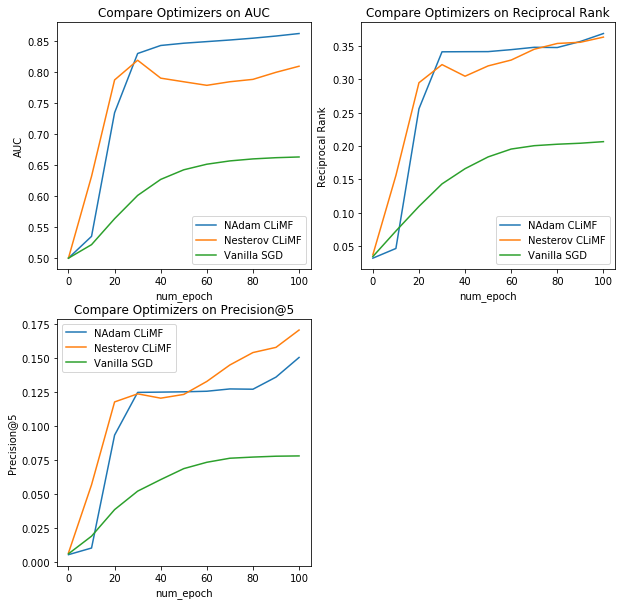

In [87]:
plt.figure(figsize=(10,10))

xs = np.arange(len(tst_climf_auc_climf_nadam)) * eval_interval
ax1 = plt.subplot(221)
# plot auc
plot_metrics({"NAdam CLiMF" : (xs, tst_climf_auc_climf_nadam), \
              "Nesterov CLiMF" : (xs, tst_climf_auc2), \
              "Vanilla SGD" : (xs, tst_climf_auc)}, \
              "num_epoch", "AUC", "Compare Optimizers on AUC", ax1)

ax2 = plt.subplot(222)
plot_metrics({"NAdam CLiMF" : (xs, tst_climf_rr_climf_nadam), \
              "Nesterov CLiMF" : (xs, tst_climf_rr2), \
              "Vanilla SGD" : (xs, tst_climf_rr)}, \
              "num_epoch", "Reciprocal Rank", "Compare Optimizers on Reciprocal Rank", ax2)

ax3 = plt.subplot(223)
plot_metrics({"NAdam CLiMF" : (xs, tst_climf_prec5_climf_nadam), \
              "Nesterov CLiMF" : (xs, tst_climf_prec52), \
              "Vanilla SGD" : (xs, tst_climf_prec5)}, \
              "num_epoch", "Precision@5", "Compare Optimizers on Precision@5", ax3)

plt.show()

# KOS Warp

In [92]:
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k

durations = []
tst_koswarp_auc = []
tst_koswarp_prec5 = []
tst_koswarp_rr = []

kos_nadam = NAdam(lr=1e-5)

kos_model = KosWARP(optim=kos_nadam, item_reg=0.2, user_reg=0.2)
for epoch in range(num_epochs+1):
    start = time.time()
    kos_model.fit(train, reset=False)
    if (epoch % eval_interval) == 0 or epoch == num_epochs:
        duration = time.time() - start
        durations.append(duration)    
        tst_auc = auc_score(kos_model, test, train_interactions=train).mean()
        tst_prec5 = precision_at_k(kos_model, test, train_interactions=train, k=5).mean()
        tst_rr = reciprocal_rank(kos_model, test, train_interactions=train).mean()
        tst_koswarp_auc.append(tst_auc)
        tst_koswarp_prec5.append(tst_prec5)
        tst_koswarp_rr.append(tst_rr)
        print("iteration %d took %.4f, auc: %.4f, p@5: %.4f, rr: %.4f" % \
              (epoch, duration, tst_auc, tst_prec5, tst_rr))

initializing embeddings and biases
iteration 0 took 22.5784, auc: 0.6893, p@5: 0.0337, rr: 0.1092
iteration 10 took 22.2268, auc: 0.8303, p@5: 0.0594, rr: 0.1687
iteration 20 took 25.6356, auc: 0.8230, p@5: 0.0475, rr: 0.1599
iteration 30 took 30.0618, auc: 0.8182, p@5: 0.0316, rr: 0.0942
iteration 40 took 27.4668, auc: 0.8373, p@5: 0.0664, rr: 0.2142
iteration 50 took 28.6866, auc: 0.8391, p@5: 0.0358, rr: 0.1320
iteration 60 took 28.0427, auc: 0.8453, p@5: 0.0460, rr: 0.1425
iteration 70 took 30.4967, auc: 0.8468, p@5: 0.0418, rr: 0.1589
iteration 80 took 27.8426, auc: 0.8482, p@5: 0.0594, rr: 0.1501
iteration 90 took 27.1085, auc: 0.8511, p@5: 0.0662, rr: 0.1942
iteration 100 took 26.9385, auc: 0.8518, p@5: 0.0696, rr: 0.1757


## WARP

In [93]:
durations = []
tst_warp_auc = []
tst_warp_prec5 = []
tst_warp_rr = []

warp_nadam = NAdam(lr=1e-5)
model = WARPNaive(optim=warp_nadam, item_reg=0.2, user_reg=0.2)

for epoch in range(num_epochs+1):
    start = time.time()
    model.fit(train, reset=False)
    if (epoch % eval_interval) == 0 or epoch == num_epochs:
        duration = time.time() - start
        durations.append(duration)    
        tst_auc = auc_score(model, test, train_interactions=train).mean()
        tst_prec5 = precision_at_k(model, test, train_interactions=train, k=5).mean()
        tst_rr = reciprocal_rank(model, test, train_interactions=train).mean()
        tst_warp_auc.append(tst_auc)
        tst_warp_prec5.append(tst_prec5)
        tst_warp_rr.append(tst_rr)
        print("warp iteration %d took %.4f, auc: %.4f, p@5: %.4f, rr: %.4f" % \
              (epoch, duration, tst_auc, tst_prec5, tst_rr))

initializing embeddings and biases
warp iteration 0 took 23.7074, auc: 0.6390, p@5: 0.0240, rr: 0.0899
warp iteration 10 took 22.5867, auc: 0.7863, p@5: 0.0422, rr: 0.1576
warp iteration 20 took 23.9839, auc: 0.7892, p@5: 0.0420, rr: 0.1588
warp iteration 30 took 28.8516, auc: 0.7903, p@5: 0.0420, rr: 0.1589
warp iteration 40 took 29.1984, auc: 0.7898, p@5: 0.0416, rr: 0.1557
warp iteration 50 took 26.3169, auc: 0.7917, p@5: 0.0420, rr: 0.1589
warp iteration 60 took 25.6939, auc: 0.7920, p@5: 0.0416, rr: 0.1588
warp iteration 70 took 31.8494, auc: 0.7916, p@5: 0.0416, rr: 0.1524
warp iteration 80 took 27.7136, auc: 0.7914, p@5: 0.0416, rr: 0.1581
warp iteration 90 took 31.5767, auc: 0.7918, p@5: 0.0420, rr: 0.1587
warp iteration 100 took 23.3293, auc: 0.7920, p@5: 0.0422, rr: 0.1566


## BPR Class

In [96]:
durations = []
tst_bpr_auc = []
tst_bpr_prec5 = []
tst_bpr_rr = []

bpr_nadam = NAdam(lr=1e-5)
bpr_model = BPR(optim=bpr_nadam, item_reg=0.2, user_reg=0.2)
for epoch in range(num_epochs + 1):
    start = time.time()
    bpr_model.fit(train, reset=False)
    if (epoch % eval_interval) == 0 or epoch == num_epochs:
        duration = time.time() - start
        durations.append(duration)    
        tst_auc = auc_score(bpr_model, test, train_interactions=train).mean()
        tst_prec5 = precision_at_k(bpr_model, test, train_interactions=train, k=5).mean()
        tst_rr = reciprocal_rank(bpr_model, test, train_interactions=train).mean()
        tst_bpr_auc.append(tst_auc)
        tst_bpr_prec5.append(tst_prec5)
        tst_bpr_rr.append(tst_rr)
        print("iteration %d took %.4f, auc: %.4f, p@5: %.4f, rr: %.4f" % (epoch, duration, tst_auc, tst_prec5, tst_rr))

initializing embeddings and biases
iteration 0 took 21.0463, auc: 0.6449, p@5: 0.0225, rr: 0.0832
iteration 10 took 28.0494, auc: 0.7856, p@5: 0.0422, rr: 0.1489
iteration 20 took 23.0729, auc: 0.7888, p@5: 0.0420, rr: 0.1526
iteration 30 took 22.8645, auc: 0.7888, p@5: 0.0424, rr: 0.1618
iteration 40 took 22.7877, auc: 0.7888, p@5: 0.0420, rr: 0.1622
iteration 50 took 22.9081, auc: 0.7899, p@5: 0.0420, rr: 0.1586
iteration 60 took 22.7638, auc: 0.7916, p@5: 0.0422, rr: 0.1587
iteration 70 took 22.3647, auc: 0.7929, p@5: 0.0420, rr: 0.1588
iteration 80 took 22.3777, auc: 0.7931, p@5: 0.0420, rr: 0.1589
iteration 90 took 21.8342, auc: 0.7921, p@5: 0.0420, rr: 0.1580
iteration 100 took 19.3183, auc: 0.7935, p@5: 0.0420, rr: 0.1580


# compare algos

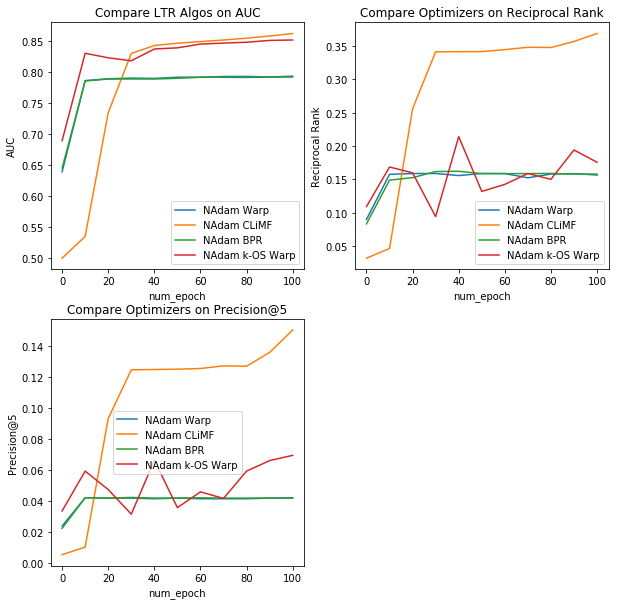

In [102]:
plt.figure(figsize=(10,10))

xs = np.arange(len(tst_climf_auc_climf_nadam)) * eval_interval
ax1 = plt.subplot(221)
# plot auc
plot_metrics({"NAdam CLiMF" : (xs, tst_climf_auc_climf_nadam), \
              "NAdam BPR" : (xs, tst_bpr_auc), \
              "NAdam Warp" : (xs, tst_warp_auc), \
              "NAdam k-OS Warp" : (xs, tst_koswarp_auc)}, \
              "num_epoch", "AUC", "Compare LTR Algos on AUC", ax1)


ax2 = plt.subplot(222)
plot_metrics({"NAdam CLiMF" : (xs, tst_climf_rr_climf_nadam), \
              "NAdam BPR" : (xs, tst_bpr_rr), \
              "NAdam Warp" : (xs, tst_warp_rr), \
              "NAdam k-OS Warp" : (xs, tst_koswarp_rr)}, \
              "num_epoch", "Reciprocal Rank", "Compare Optimizers on Reciprocal Rank", ax2)

ax3 = plt.subplot(223)
plot_metrics({"NAdam CLiMF" : (xs, tst_climf_prec5_climf_nadam), \
              "NAdam BPR" : (xs, tst_bpr_prec5), \
              "NAdam Warp" : (xs, tst_warp_prec5), \
              "NAdam k-OS Warp" : (xs, tst_koswarp_prec5)}, \
              "num_epoch", "Precision@5", "Compare Optimizers on Precision@5", ax3)


plt.show()